# File and libraries

In [23]:
import pandas as pd
import numpy as np


file_tag = "Google Merch Store 2024-2025"


# DSLabs functions

In [24]:
%run "scripts/dslabs_functions.py"


# Data functions

In [25]:
%run "scripts/data_functions.py"


data_functions loaded


# Load

In [26]:
test_data=True
# test_data=False


train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

target='Sessions'

# Prepare the training and testing data
trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 2024-01-14 to 2024-12-09
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sessions                         331 non-null    float64
 1   Seven-day active users           331 non-null    float64
 2   28-day active users              331 non-null    float64
 3   Events per session               331 non-null    float64
 4   Add to baskets                   331 non-null    float64
 5   Average purchase revenue         331 non-null    float64
 6   Purchase revenue                 331 non-null    float64
 7   Average session duration         331 non-null    float64
 8   ARPU                             331 non-null    float64
 9   ARPPU                            331 non-null    float64
 10  Views per user                   331 non-null    float64
 11  Total users                      331 non-null    float64
 12  Pro

# ARIMA

## ARIMA Model Creation

In [30]:
from statsmodels.tsa.api import VAR

# Combine the target variable with the features for VAR
train_var = train
test_var = test

# Fit the VAR model
model = VAR(train_var)
fitted_model = model.fit(maxlags=5, ic='aic')  # Reduced maxlags to 5
print(fitted_model.summary())


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


LinAlgError: 33-th leading minor of the array is not positive definite

## ARIMA Model Plot Diagnostics

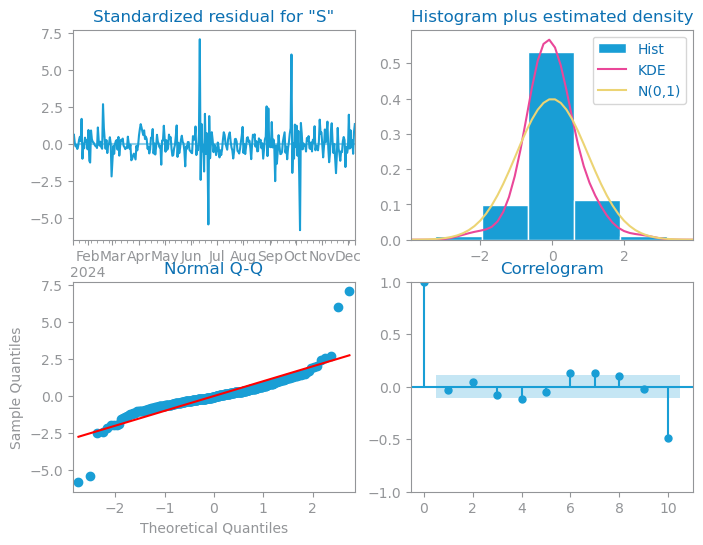

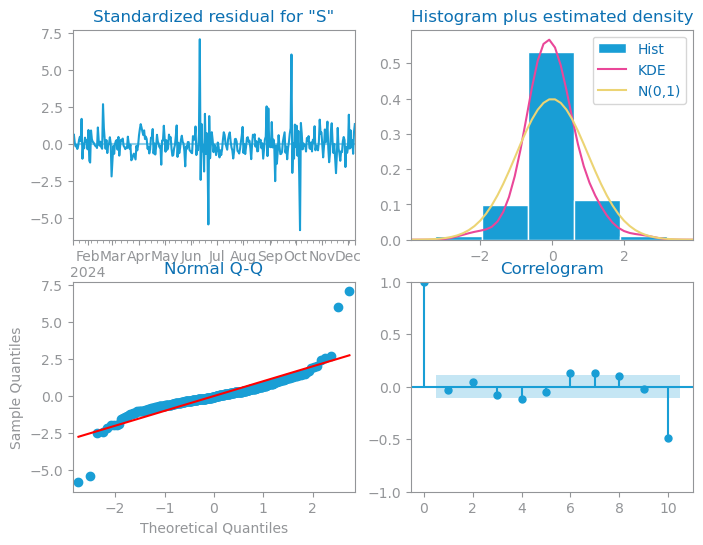

In [159]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Model Study

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

ARIMA best results achieved with (p,d,q)=(3, 0, 5) ==> measure=0.00


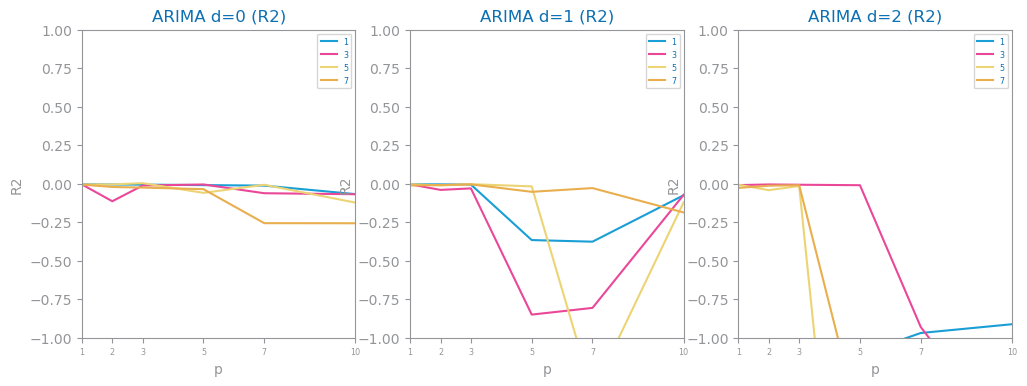

In [160]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params


from matplotlib.pyplot import savefig

best_model, best_params = arima_study(trnY, trnY, measure=measure)
savefig(f"images/{file_tag}_arima_{measure}_study.png")

## ARIMA Evaluate

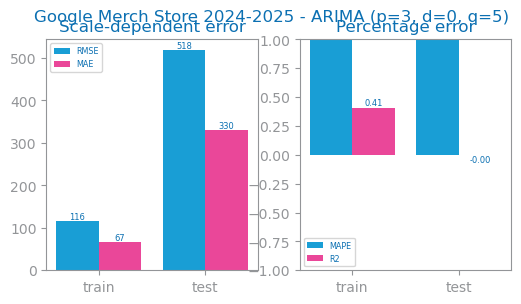

In [161]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_eval.png")

## ARIMA Plot

<Axes: xlabel='Date', ylabel='Sessions'>

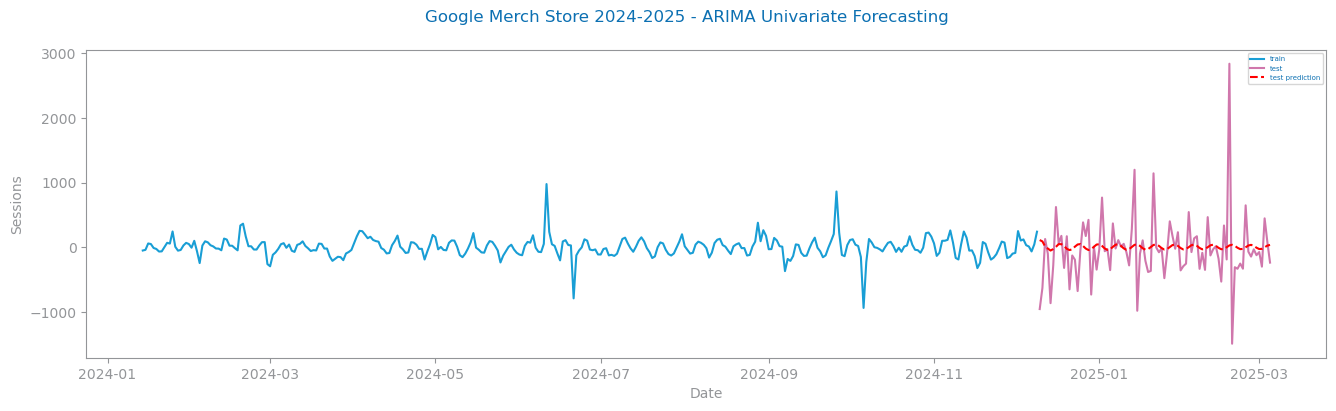

In [162]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)

# LSTMs

# PIP INSTALL TORCH. not in anaconda package by default

## LSTMs Study

In [171]:

from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torch



def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX, dtype=torch.float32), tensor(setY, dtype=torch.float32)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]




RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 4

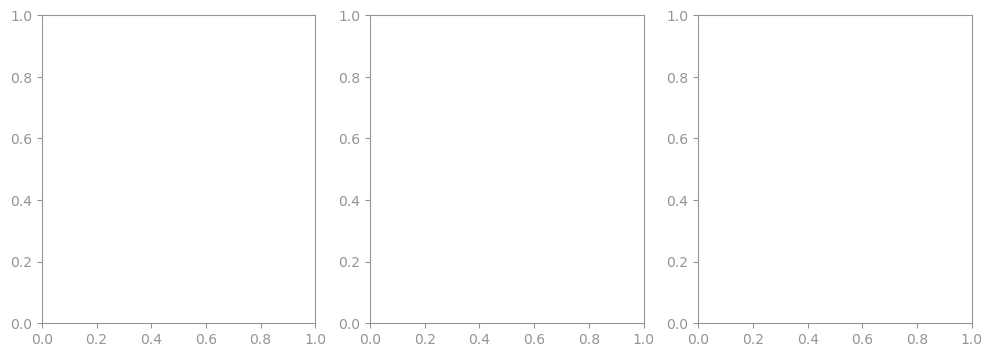

In [172]:
from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


best_model, best_params = lstm_study(trnY, tstY, nr_episodes=3000, measure=measure)


## LSTM Evaluate

In [ ]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
best_length = params[0]
trnX_lstm, trnY_lstm = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX_lstm, tstY_lstm = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX_lstm)
prd_tst = best_model.predict(tstX_lstm)

plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/{file_tag}_lstms_{measure}_eval.png")

## LSTM Plot